In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# Load data into the kernel 
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
gender_data = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

--- Training Data ---

First 5 rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0          

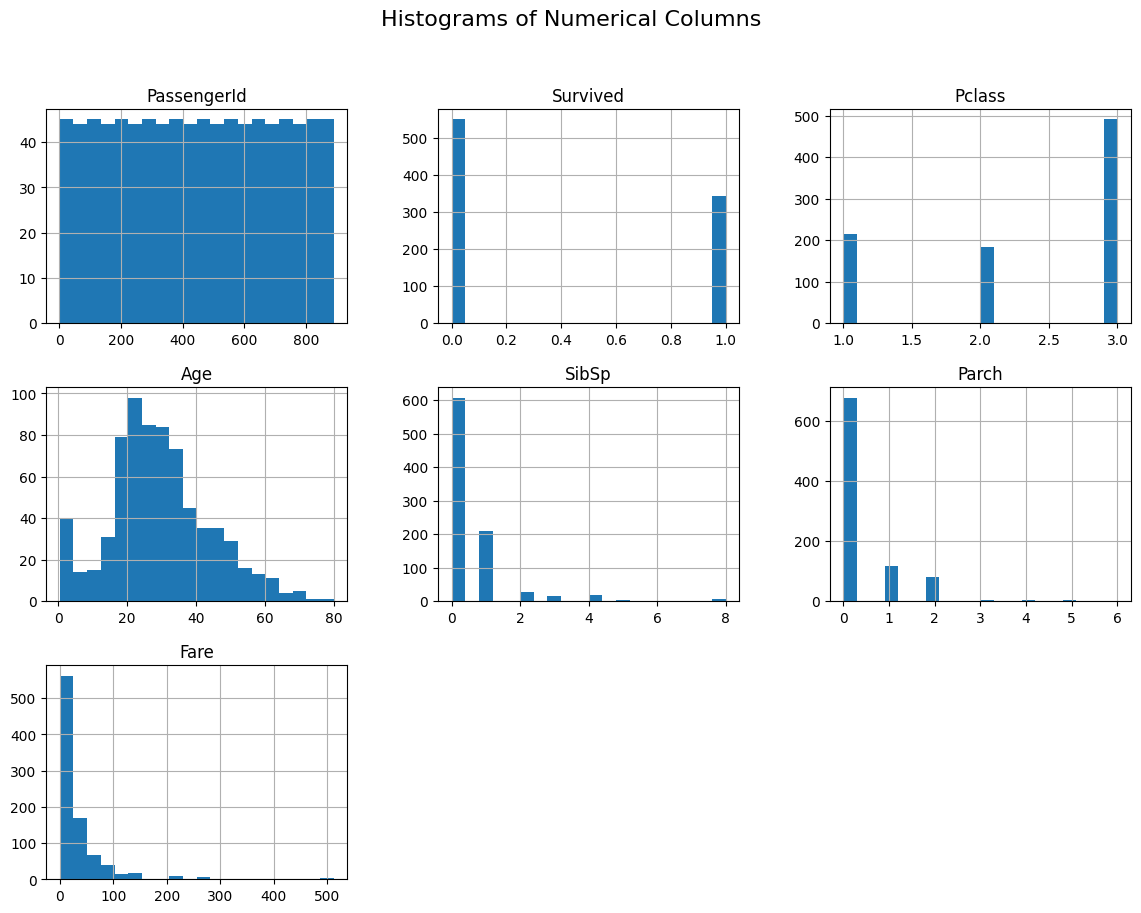

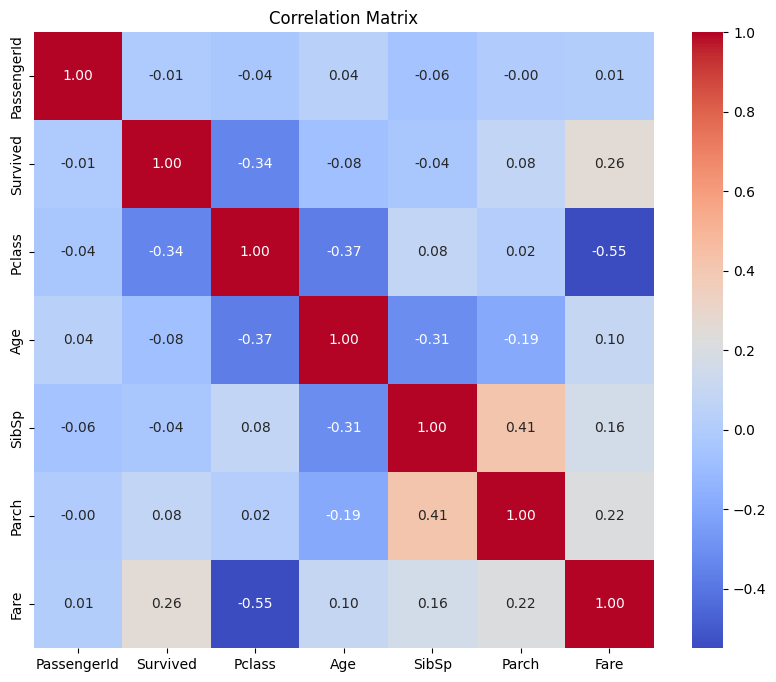

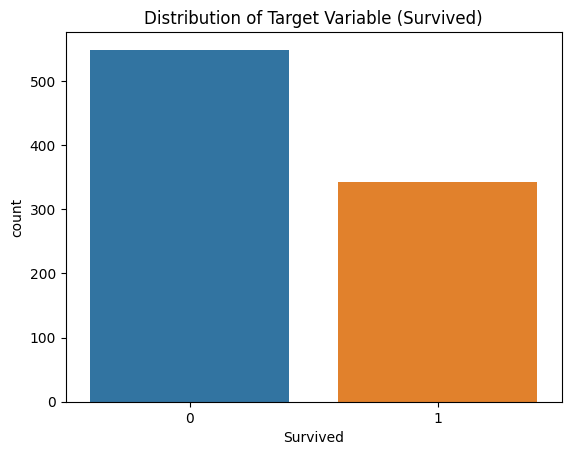

--- Test Data ---

First 5 rows:
   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S   

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       

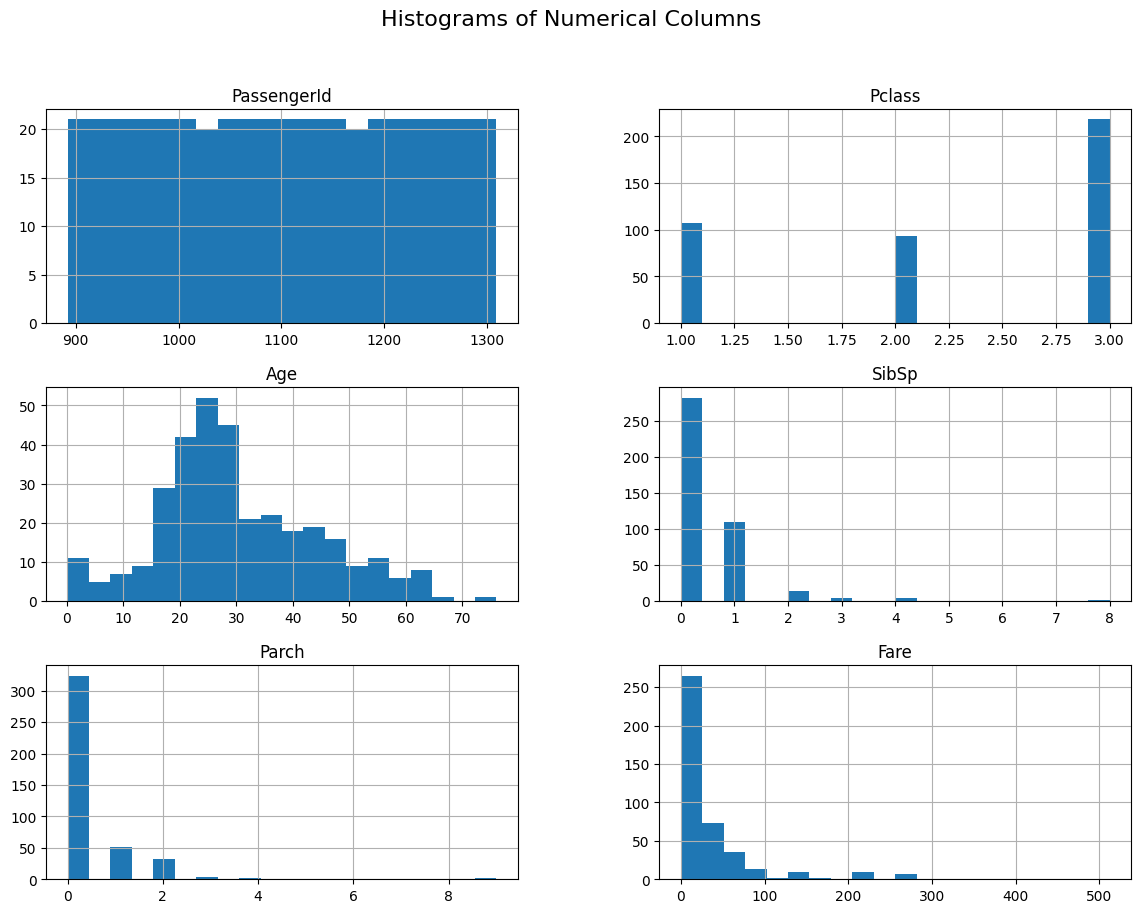

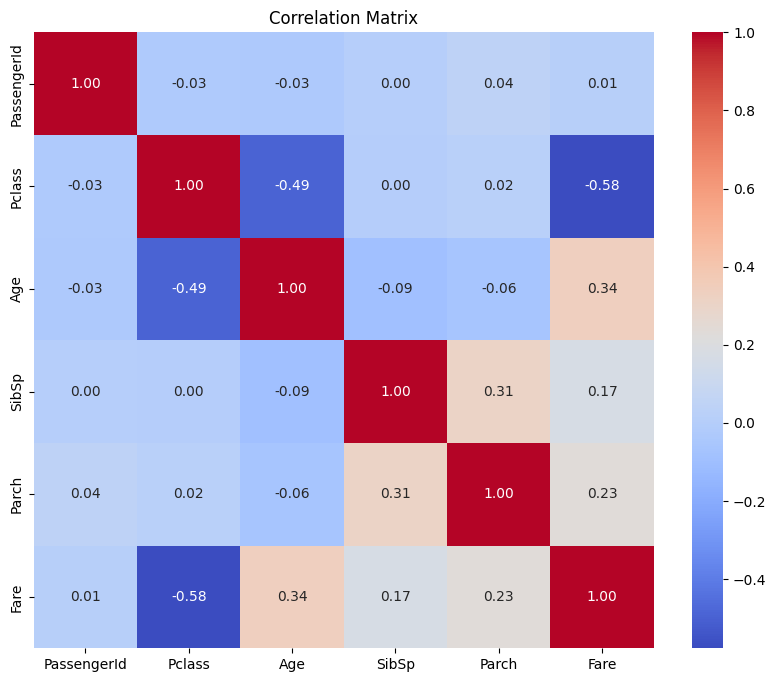

In [3]:
# First inspection of the data set
import seaborn as sns
import matplotlib.pyplot as plt

# Function to visualize data
def visualize_data(df, title="Dataset Overview"):
    print(f"--- {title} ---\n")
    
    # Display the first 5 rows of the dataset
    print("First 5 rows:")
    print(df.head(), "\n")
    
    # Show basic information about the dataset
    print("Basic Information:")
    print(df.info(), "\n")
    
    # Show descriptive statistics for numerical columns
    print("Descriptive Statistics:")
    print(df.describe(), "\n")
    
    # Check for missing values in each column
    print("Missing Values per Column:")
    print(df.isnull().sum(), "\n")
    
    # Visualizations
    print("--- Visualizations ---\n")
    
    # Plot histograms for numerical columns
    numeric_cols = df.select_dtypes(include=np.number).columns
    df[numeric_cols].hist(bins=20, figsize=(14, 10))
    plt.suptitle("Histograms of Numerical Columns", fontsize=16)
    plt.show()
    
    # Plot correlation matrix for numerical columns
    corr_matrix = df[numeric_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()
    
    # Plot the distribution of the target variable if it exists
    if "Survived" in df.columns:
        sns.countplot(x="Survived", data=df)
        plt.title("Distribution of Target Variable (Survived)")
        plt.show()

# Visualize the training data
visualize_data(train_data, title="Training Data")

# Visualize the test data
visualize_data(test_data, title="Test Data")

Observations:
There is no strong correlation (above 80%) between the target variable (Survived) and any other features. Therefore, all features can be considered for further evaluation.
The correlation distribution is similar between the training and test datasets, indicating consistent data behavior.
The dataset is reasonably balanced, meaning additional rebalancing techniques or engineering are not required.
This is a straightforward machine learning classification problem, making it suitable for standard approaches without extensive modifications.

In [4]:
# Prepare data, set gender numerical 
# Fill missing age and fare with median 
def prepare_data(df):
    # change gender into numbers / encode
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    
    # filling missing values in age & fare 
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    
    # Missing embarked into S (only 5 or so), & Encoding 
    df['Embarked'] = df['Embarked'].fillna('S')
    df['Embarked'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
    
    # Dropping non relevant features: Cabin, is directly related to class
    return df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

# Prepare the data and separate into test and train data sets 
X = prepare_data(train_data)
y = train_data['Survived']
X_test = prepare_data(test_data)


Test train split is not needed, since this is a kaggle competition. But we need for later on a validation data, similar to test train split :D 

In [5]:
# Import all required libraries for the ML and DL process 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [6]:
# Prepare data for the training and validation 
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

# Scale features for models that require scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")


X_train shape: (712, 7)
X_val shape: (179, 7)
y_train shape: (712,)
y_val shape: (179,)
X_train_scaled shape: (712, 7)
X_val_scaled shape: (179, 7)


In [7]:
# All models in one big step, for comparisson 
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
}

# Add an artificial neural network (ANN)
def create_ann(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    if name == "Support Vector Machine" or name == "K-Nearest Neighbors":
        # Use scaled data for SVM and KNN
        model.fit(X_train_scaled, y_train)
        predictions = model.predict(X_val_scaled)
    else:
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)
    results[name] = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}




Training Logistic Regression...
Training Random Forest...
Training XGBoost...
Training Gradient Boosting...
Training AdaBoost...
Training Naive Bayes...
Training Support Vector Machine...
Training K-Nearest Neighbors...


In [8]:
# Train and evaluate the ANN separately
print("Training Artificial Neural Network...")
ann = create_ann(X_train.shape[1])
ann.fit(X_train_scaled, y_train, epochs=20, batch_size=32, verbose=0)
ann_predictions = (ann.predict(X_val_scaled) > 0.5).astype(int)

# Calculate ANN metrics
results["Artificial Neural Network"] = {
    "Accuracy": accuracy_score(y_val, ann_predictions),
    "Precision": precision_score(y_val, ann_predictions),
    "Recall": recall_score(y_val, ann_predictions),
    "F1 Score": f1_score(y_val, ann_predictions)
}

Training Artificial Neural Network...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [9]:
# Display results of all the different models
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)


Model Comparison:
                           Accuracy  Precision    Recall  F1 Score
Logistic Regression        0.810056   0.785714  0.743243  0.763889
Random Forest              0.815642   0.788732  0.756757  0.772414
XGBoost                    0.787709   0.736842  0.756757  0.746667
Gradient Boosting          0.810056   0.812500  0.702703  0.753623
AdaBoost                   0.804469   0.767123  0.756757  0.761905
Naive Bayes                0.776536   0.712500  0.770270  0.740260
Support Vector Machine     0.815642   0.815385  0.716216  0.762590
K-Nearest Neighbors        0.804469   0.782609  0.729730  0.755245
Artificial Neural Network  0.826816   0.852459  0.702703  0.770370


Best models are Random Forest, SVM and ANN. Now I am going to optimize. 
Hyperparameter tuning with techniques like: Grid Search, Random Search and Bayesian Optimization. 
I am also taking XGBoost into account, because I believe it has hidden potential. 

In [10]:
# Optimization for the random forest model
from sklearn.model_selection import GridSearchCV

# Define parameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform Grid Search
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, scoring='accuracy', cv=5, verbose=1)
rf_grid_search.fit(X_train, y_train)

# Get best parameters and accuracy
print("Best Random Forest Parameters:", rf_grid_search.best_params_)
print("Best Random Forest Accuracy:", rf_grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Best Random Forest Accuracy: 0.8230178272431793


In [11]:
# optimization of the SVM model
# Define parameter grid
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Initialize SVM model
svm = SVC(random_state=42)

# Perform Grid Search
svm_grid_search = GridSearchCV(estimator=svm, param_grid=svm_param_grid, scoring='accuracy', cv=5, verbose=1)
svm_grid_search.fit(X_train_scaled, y_train)  # Use scaled data for SVM

# Get best parameters and accuracy
print("Best SVM Parameters:", svm_grid_search.best_params_)
print("Best SVM Accuracy:", svm_grid_search.best_score_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best SVM Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM Accuracy: 0.8215896779277061


In [12]:
# Optimization of the XGBoost model 
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid for XGBoost (already I have run some tests -> these hyperparameters)
xgb_param_grid = {
    'n_estimators': [100],             # Fix to one value
    'max_depth': [3, 5],               # Slightly varied
    'learning_rate': [0.05, 0.1],      # Key hyperparameter
    'subsample': [0.8],                # Fixed to most common value
    'colsample_bytree': [0.8],         # Fixed to most common value
    'gamma': [0, 1],                   # Minor regularization variation
    'min_child_weight': [1, 5]         # Focus on typical values
}
print("Grid parameters defined")

# Initialize XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
print("Model initialized")

# Perform Grid Search
xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, scoring='accuracy', cv=5, verbose=1)
print("GridSearch initialized")
xgb_grid_search.fit(X_train, y_train)
print("Gridsearch/fitting finished")

# Get best parameters and accuracy
print("Best XGBoost Parameters:", xgb_grid_search.best_params_)
print("Best XGBoost Accuracy:", xgb_grid_search.best_score_)

print("Before accuracy was at 0.839---> so we are not improoving very much, lets stick to these values!")

Grid parameters defined
Model initialized
GridSearch initialized
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Gridsearch/fitting finished
Best XGBoost Parameters: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Best XGBoost Accuracy: 0.8398699891657639
Before accuracy was at 0.839---> so we are not improoving very much, lets stick to these values!


Optimization of the dense neural network: 
EarlyStopping, Dropout Layers, track and plot Training history 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,617 (92.25 KB)

 Trainable params: 23,489 (91.75 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6143 - loss: 0.8881 - val_accuracy: 0.7374 - val_loss: 0.8289 - learning_rate: 5.0000e-04
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7326 - loss: 0.7667 - val_accuracy: 0.7374 - val_loss: 0.7606 - learning_rate: 5.0000e-04
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7402 - loss: 0.7413 - val_accuracy: 0.7039 - val_loss: 0.7798 - learning_rate: 5.0000e-04
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7333 - loss: 0.7483 - val_accuracy: 0.6983 - val_loss: 0.9275 - learning_rate: 5.0000e-04
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8121 - loss: 0.7124 - val_accuracy: 0.7430 - val_loss: 1.0746 - learning_rate: 5.0000e-04
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7657 - loss: 0.7388 - val_accuracy: 0.7374 - val_loss: 1.2234 - learning_rate: 5.0000e-04
Epoch 7/200
42/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8192 

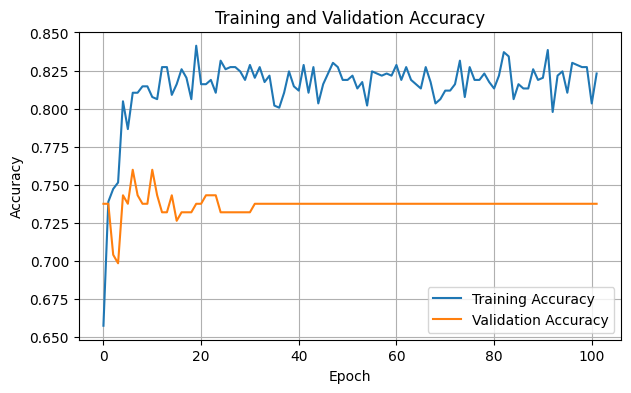

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Step 1: Build the Neural Network Model
# Dropout leves: start with small and have higher ones in the later layers 
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Explicitly define the input shape
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),  # Dropout layer to reduce overfitting
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(), 
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Step 2: Compile the model with binary_crossentropy for binary classification
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])  # Accuracy as the primary metric

# Display the model architecture
model.summary()

# Step 3: Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', patience=100, min_delta=0.0001, restore_best_weights=True, verbose=1
)

# Step 4: Train the Model
# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6, 
    verbose=1
)
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val, y_val),
    epochs=200,              # Reduced epochs - helps manage memory usage
    batch_size=16,          # Smaller batch size - helps manage memory usage
    callbacks=[early_stopping, lr_scheduler],  # Early stopping to prevent overfitting and adding lr_scheduler
    verbose=1
)

# Step 5: Plot Training and Validation Accuracy
plt.figure(figsize=(7, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()



As we can see the accuracy is not increasing further. So this means we have reached the saturation of how good the DNN can become. And it does not look like overfitting. 

Sadly there is an environment problem with the keras CVGrid Api - so I had to do this manually. 

Nevertheless, the best training accuracy of the DNN is at around: 83% with large oscillations, while the 
accuracy of the XGBoost is at: 83.98% so I will submit with the XGBoost. 

In [14]:
# Predictions with the best xgboost model 
best_model = xgb_grid_search.best_estimator_
predictions = best_model.predict(X_test)

print(predictions)
print(X_test.head())
print(test_data.head())
print(X_test.shape)
print(test_data.shape)

[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 0]
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0       3    0  34.5      0      0   7.8292         1
1       3    1  47.0      1      0   7.0000

In [15]:
# Submission-Data creation
output = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': predictions})
output.to_csv('submission.csv', index=False)

print(output.head(50))
print("Submission file created!")


    PassengerId  Survived
0           892         0
1           893         0
2           894         0
3           895         0
4           896         0
5           897         0
6           898         1
7           899         0
8           900         1
9           901         0
10          902         0
11          903         0
12          904         1
13          905         0
14          906         1
15          907         1
16          908         0
17          909         0
18          910         0
19          911         1
20          912         0
21          913         0
22          914         1
23          915         0
24          916         1
25          917         0
26          918         1
27          919         0
28          920         0
29          921         0
30          922         0
31          923         0
32          924         1
33          925         0
34          926         1
35          927         0
36          928         0
37          

In [16]:
import os
print(os.listdir('.'))

['__notebook__.ipynb', 'submission.csv']
